In [162]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# -----------------------------
# 2. LOAD IMAGES
# -----------------------------
def loading_images(data_directory,mode, image_size):

    """
    Loads images from the specified directory, resizes them, flattens them into vectors,
    and assigns labels based on folder names.

    Assumes each class has a subfolder with 'train' images.

    Arguments:
    data_directory -- string, path to the root directory containing class folders
    mode -- string, either 'train' or 'test' to specify which subfolder to load
    image_size -- tuple(int, int), size to which each image will be resized (width, height)

    Returns:
    X -- list of numpy arrays, each array is a flattened image vector
    y -- list of integers, labels corresponding to each image
    label_dict-- dictionary mapping class names (folder names) to integer labels, e.g., {'Dogs': 0, 'Cats': 1}
    """
    X = [] # Empty list for storing flattened image vectors 
    y = [] # Empty list for storing interger labels (0 and 1)
    
    # Get class labels from folder names and map to integers
    
    labels = os.listdir(data_directory) # lists all the sub-folders of the specified root directory, that contain the images
    label_dict = {label: i for i, label in enumerate(labels)}
    
    # Loop through each class folder and creates path for the mode
    for label in labels:
        folder = os.path.join(data_directory, label, mode)
        if not os.path.isdir(folder):
            continue  # Skip if train/test folder doesn't exist

        Files = os.listdir(folder)
        for filename in Files:
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(folder, filename)
               # Open image and convert to RGB
                img = Image.open(image_path).convert("RGB")
              # Resizes the loaded image into the size specified above (64x64 pixels)
                img_resized = img.resize(image_size)
              # Creates a numpy array from the resized image
                X_array = np.array(img_resized)
             # Flattens the array into a vector and appends it into X
                X.append(X_array.flatten())
             # Appends each class label into a list "y"
                y.append(label_dict[label])

    # Converts X into an array and normalizes all pixel values to [0,1]
    X_norm = (np.array(X))/255.0
    # Converts y labels into an array
    y_array = np.array(y)
    
    return X_norm, y_array, label_dict
    

# ------------------------------------
# 3. PARAMETER INITIALIZATION FUNCTION
# ------------------------------------

def parameter_init(input_size, hidden_1, hidden_2, hidden_3, output_size):
    """Initializes weights and biases for a 4-layer neural network.
    
    Arguments:    
    input_size -- int, number of input features (size of the input layer)
    hidden_1 -- int, number of units in the first hidden layer
    hidden_2 -- int, number of units in the second hidden layer
    hidden_3 -- int, number of units in the third hidden layer
    output_size -- int, number of units in the output layer
    
    Returns:
    parameters -- dict containing initialized weights (W1, W2, W3, W4) 
                  and biases (b1, b2, b3, b4) for each layer

    Notes:
    ------
    - Weights are initialized using He and Xavier/Glorot Initialization for ReLU 
      and sigmoid layers respectively to improve gradient flow.
    - Biases are initialized to zero.
    """
    np.random.seed(1)

    # Weights: initialized with small random values (scaled by 0.01)
    # to prevent exploding activations and help stable learning.
    # Biases: initialized to zero.
    W1 = np.random.randn(hidden_1, input_size)*np.sqrt(2. / input_size)
    b1 = np.zeros((hidden_1, 1))
    W2 = np.random.randn(hidden_2, hidden_1)*np.sqrt(2. / hidden_1)
    b2 = np.zeros((hidden_2,1))
    W3 = np.random.randn(hidden_3, hidden_2)*np.sqrt(2. / hidden_2)
    b3 = np.zeros((hidden_3,1))
    W4 = np.random.randn(output_size, hidden_3)*np.sqrt(1. / hidden_3)
    b4 = np.zeros((output_size,1))
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3":W3, "b3":b3, "W4":W4, "b4":b4}
    return parameters
    

# -----------------------------
# 4. ACTIVATION FUNCTIONS
# -----------------------------

# ReLU activation function for the hidden layers
def relu(Z):
    """
    ReLU activation function.

    Arguments:
    ----------
    Z : numpy.ndarray
        Linear input to the activation function.

    Returns:
    --------
    A : numpy.ndarray
        Output after applying ReLU (max(0, Z)).
    """
    A = np.maximum(0,Z)
    return A
def relu_derivative(Z):
    """
    Derivative of the ReLU activation function.

    Arguments:
    ----------
    Z : numpy.ndarray
        Linear input to ReLU.

    Returns:
    --------
    dZ : numpy.ndarray
        Gradient of ReLU (1 for Z > 0, else 0).
    """
    return (Z>0).astype(float)
def sigmoid(Z4):
    """
    Sigmoid activation function (used in output layer for binary classification).

    Arguments:
    ----------
    Z : numpy.ndarray
        Linear input to the activation function.

    Returns:
    --------
    y_hat : numpy.ndarray
        Output after applying sigmoid.
    """
    Z4 = np.clip(Z4, -500, 500) # Clipping Z values to avoid overflow
    y_hat = 1/(1 + np.exp(-Z4))
    return y_hat

# Sigmoid activation function for the output layer
def sigmoid_derivative(y_hat):
    """
    Derivative of the sigmoid activation function.

    Arguments:
    ----------
    y_hat : numpy.ndarray
        Output of the sigmoid function.

    Returns:
    --------
    dA : numpy.ndarray
        Gradient of sigmoid wrt its input.
    """
    y_hat_derivative = y_hat*(1-y_hat)
    return y_hat_derivative

# -------------------------------
# 5. FORWARD BACKWARD PROPAGATION
# -------------------------------

# Before calling this function, make sure to initialize parameters:
# parameters = parameter_init(input_size, hidden_1, hidden_2, hidden_3, output_size)

def forward_prop(X, parameters):
    """
    Performs forward propagation through the network.

    Arguments:
    ----------
    X : numpy.ndarray
        Input data of shape (input_size, m).
    parameters : dict
        Dictionary containing network parameters (weights and biases).

    Returns:
    --------
    cache : dict
        Stores intermediate values (Z and A for each layer) 
        needed for backpropagation.
    """
    # Retrieve weights and biases from dictionary
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]
    W3, b3 = parameters["W3"], parameters["b3"]
    W4, b4 = parameters["W4"], parameters["b4"]
    
    # Forward Computations
    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)  
    Z2 = W2.dot(A1) + b2
    A2 = relu(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = relu(Z3)
    Z4 = W4.dot(A3) + b4
    y_hat = sigmoid (Z4)

    cache = {"Z1":Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3,"A3": A3,"Z4": Z4, "A4": y_hat}
    return cache

def Cost_function(Y, y_hat):
    """
    Computes binary cross-entropy cost.

    Arguments:
    ----------
    y : numpy.ndarray
        True labels (0 or 1) of shape (1, m).
    y_hat : numpy.ndarray
        Predicted probabilities of shape (1, m).

    Returns:
    --------
    cost : float
        Cross-entropy loss.
    """
    m = Y.shape[1] # number of training examples

    eps = 1e-15 # prevent log(0)
    y_hat = np.clip(y_hat, eps, 1 - eps)
    cost = -np.sum(Y * np.log(y_hat) + (1 - Y) * np.log(1 - y_hat)) / m
    cost = np.squeeze(cost) 
    return cost
    
# -----------------------
# 5. BACKWARD PROPAGATION
# -----------------------

def backward_prop(parameters, cache, X_train, y_train):
    """
    Performs backward propagation to compute gradients.

    Arguments:
    ----------
    parameters : dict
        Network parameters (weights and biases).
    cache : dict
        Forward propagation results (Z and A values).
    X_train : numpy.ndarray
        Training input data of shape (input_size, m).
    y_train : numpy.ndarray
        True labels of shape (1, m).

    Returns:
    --------
    derivatives : dict
        Gradients of weights and biases for each layer.
    """
    W1, W2, W3, W4 = parameters["W1"], parameters["W2"], parameters["W3"], parameters["W4"]
    A1, A2, A3, A4 = cache["A1"], cache["A2"], cache["A3"], cache["A4"]
    Z1, Z2, Z3, Z4 = cache["Z1"], cache["Z2"], cache["Z3"], cache["Z4"]
    
    m = X_train.shape[1]

    # Layer 4 (output layer)
    dZ4 = A4 - y_train
    dW4 = (1/m) * np.dot(dZ4, A3.T)
    db4 = (1/m) * np.sum(dZ4, axis=1, keepdims=True)

    # Hidden Layer 3
    dZ3 = np.dot(W4.T, dZ4) * relu_derivative(Z3)
    dW3 = (1/m) * np.dot(dZ3, A2.T)
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)

    # Hidden Layer 2
    dZ2 = np.dot(W3.T, dZ3) * relu_derivative(Z2)
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    # Hidden Layer 1
    dZ1 = np.dot(W2.T, dZ2) * relu_derivative(Z1)
    dW1 = (1/m) * np.dot(dZ1, X_train.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    max_grad = 1.0
    # Gradient clipping for all layers to prevent instability
    dW1 = np.clip(dW1, -max_grad, max_grad)
    db1 = np.clip(db1, -max_grad, max_grad)

    dW2 = np.clip(dW2, -max_grad, max_grad)
    db2 = np.clip(db2, -max_grad, max_grad)

    dW3 = np.clip(dW3, -max_grad, max_grad)
    db3 = np.clip(db3, -max_grad, max_grad)

    dW4 = np.clip(dW4, -max_grad, max_grad)
    db4 = np.clip(db4, -max_grad, max_grad)

    derivatives = {
        "dW4": dW4, "db4": db4,
        "dW3": dW3, "db3": db3,
        "dW2": dW2, "db2": db2,
        "dW1": dW1, "db1": db1
    }
    
    return derivatives
    
# -----------------------------
# 6. PARAMETER UPDATE
# -----------------------------

def parameter_update(parameters, derivatives, learning_rate = 1.2, Stats=False):
    """
    Updates parameters using gradient descent.

    Arguments:
    ----------
    parameters : dict
        Current weights and biases.
    derivatives : dict
        Gradients of weights and biases from backpropagation.
    learning_rate : float, optional
        Step size for gradient descent (default: 1.2).
    Stats : bool, optional
        If True, prints gradient statistics for debugging.

    Returns:
    --------
    parameters : dict
        Updated weights and biases.
    """
    L = len(parameters) // 2  # number of layers
    for l in range(1, L + 1):
        if Stats==True:
            print(f"Layer {l}: mean|dW| = {np.mean(np.abs(derivatives[f'dW{l}'])):.6f}, "
            f"mean|db| = {np.mean(np.abs(derivatives[f'db{l}'])):.6f}")
        parameters[f"W{l}"] -= learning_rate * derivatives[f"dW{l}"]
        parameters[f"b{l}"] -= learning_rate * derivatives[f"db{l}"]
    return parameters

# -------------------------------
# 7. TRAINING
# -------------------------------

def train(X, y, input_size, hidden_1, hidden_2, hidden_3, output_size, epochs=1000, show_cost_change=False):
    """
    Trains a 4-layer neural network (3 hidden layers + output layer) using 
    forward propagation, backpropagation, and gradient descent updates.

    Parameters
    ----------
    X : numpy.ndarray
        Input data matrix of shape (input_size, number_of_examples).
    y : numpy.ndarray
        True labels (binary: 0 or 1) of shape (1, number_of_examples).
    input_size : int
        Number of features in each input sample (e.g., 12288 for 64x64 RGB images).
    hidden_1 : int
        Number of neurons in the first hidden layer.
    hidden_2 : int
        Number of neurons in the second hidden layer.
    hidden_3 : int
        Number of neurons in the third hidden layer.
    output_size : int
        Number of output neurons (1 for binary classification).
    epochs : int, optional (default=1500)
        Number of training iterations.
    show_cost_change : bool, optional (default=False)
        If True, prints the cost every 10 epochs.

    Returns
    -------
    best_params : dict
        Dictionary of the best model parameters (weights and biases) 
        that achieved the lowest cost during training.
    costs : list
        List of cost values recorded at each epoch, for plotting learning curves.

    Example
    -------
    best_params, costs = train(X_train, y_train, 12288, 128, 64, 32, 1, epochs=1500, show_cost_change=True)

    # Plot cost curve
    plt.plot(range(len(costs)), costs, label="Training cost")
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.title("Cost vs Epochs")
    plt.legend()
    plt.show()
    """
    parameters = parameter_init(input_size, hidden_1, hidden_2, hidden_3, output_size)
    costs = []  # store cost for plotting
    best_cost = float("inf")
    best_params = parameters.copy()
    
    for epoch in range(epochs):
        # 1. Forward propagation
        cache = forward_prop(X, parameters)
        
        # 2. Compute cost
        cost = Cost_function(y, cache["A4"])

        # 3. Backpropagation
        derivatives = backward_prop(parameters, cache, X, y)

        # 4. Update parameters using gradient descent
        parameters = parameter_update(parameters, derivatives, learning_rate=0.001)

        # Save cost for plotting
        costs.append(cost)

        # Optionally print progress every 10 epochs
        if epoch % 10 == 0 and show_cost_change==True:
            print(f"Epoch {epoch}, Cost: {cost:.6f}")

        # Track the best model (lowest cost seen so far)
        if cost < best_cost:
            best_cost = cost
            best_params = {k: v.copy() for k, v in parameters.items()}

    return best_params, costs

# --------------------------
# 5. PREDICT AND EVALUATE
# --------------------------

def Classify(X,Y, optimum_params,label_dict, num_to_show, cols=5):
    """
    Perform prediction on input data using trained parameters and evaluate results.

    Parameters
    ----------
    X : numpy.ndarray
        Input data (features), shape (n_features, n_samples). 
        Should be the same shape used during training (e.g., flattened images).
    y : numpy.ndarray
        True labels for the data, shape (1, n_samples). 
        Labels must correspond to keys in `label_dict`.
    optimum_params : dict
        Dictionary containing the trained model parameters (weights and biases).
    label_dict : dict
        Dictionary mapping class names to integer labels. Example: {'Cats': 1, 'Dogs': 0}.
    num_to_show : int, optional (default=20)
        Number of test images to display with predictions.
    cols : int, optional (default=5)
        Number of columns in the image display grid.

    Returns
    -------
    y_pred : numpy.ndarray
        Predicted labels for the input data, shape (1, n_samples).
    fig : matplotlib.figure.Figure
        Matplotlib figure containing the grid of images with predictions.
    """

    # Forward propagation to get predictions
    cache = forward_prop(X, optimum_params)
    y_hat = cache["A4"]  # final output layer
    y_pred =(y_hat > 0.5).astype(int)  # for binary classification

    accuracy = np.mean(y_pred == Y)
    print("Test Accuracy:", accuracy)


    # Flatten predictions and true labels
    y_pred_flat = y_pred.flatten()
    y_flat = Y.flatten()

    # Compute grid layout for displaying images
    rows = (num_to_show + cols - 1) // cols  # Compute number of rows needed

    fig=plt.figure(figsize=(15, 6))  # Set figure size
   
    for i in range(num_to_show):
        plt.subplot(rows, cols, i + 1)
        img = X[:, i].reshape(64, 64, 3)  # Reshape flattened image
        plt.imshow(img.astype('uint8'))
        plt.axis('off')

         # Get labels
        true_label = "Cat" if y_flat[i] == label_dict['Cats'] else "Dog"
        pred_label = "Cat" if y_pred_flat[i] == label_dict['Cats'] else "Dog"

        # Green if correct, red if incorrect
        color = "green" if y_pred_flat[i] == y_flat[i] else "red"
        plt.title(f"{pred_label}", color=color, fontsize=10)

    plt.tight_layout()
    #plt.show()
    return y_pred


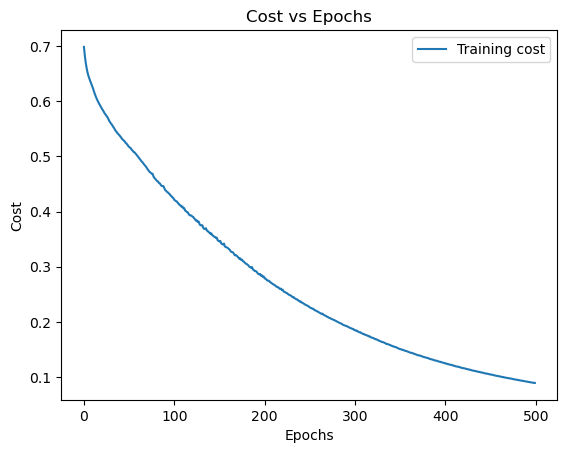

In [159]:
# --------------------------
# EXAMPLE OF LOADING IMAGES
# --------------------------

# Assigning the outputs of the "loading_images" function to their respective variables
X_train, y_train, label_dict = loading_images("../Images", "train", image_size)
X_test, y_test = loading_images("../Images", "test", image_size)[:2]

# Transpose for math: changing dimensions to (features, training_examples)
X_train, X_test = X_train.T, X_test.T
y_train, y_test = y_train.reshape(1, y_train.shape[0]), y_test.reshape(1, y_test.shape[0])


# --------------------------
# Tracking Cost
# --------------------------

best_params, costs = train(X_train, y_train, 12288,128,64,32,1, epochs=500)
# Plot the cost curve
plt.plot(range(len(costs)), costs, label="Training cost")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cost vs Epochs")
plt.legend()
plt.show()